In [1]:
from Autoencoder import *
from make_video import *

import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

1 Physical GPUs, 1 Logical GPUs


## Parameters

In [31]:
DATASET = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Dataset' ## where there is dataset
DATASET_NAME = r'bunny_video.mp4' ## Name of the video
FRAMES = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Results\Video_Frames' ## where you want to save the frames
RECONSTRUCTED = r'C:\Users\Saad.LAKES\Desktop\Autoencoders\Videos\Results\ReconVideo_Frames' ## where the reconstructed frames are saved

WIDTH = 960 ## width of the reconstrcted image
HEIGHT = 540 ## height of the reconstrcted image
FPS = 25 ## fps of the reconstrcted image
SLICES = 32 ## Number of slices to be made on the image

EMBEDDING_SIZE = 512 ## bottleneck layer nodes

In [32]:
names,fps,width,height = read_video(FRAMES,os.path.join(DATASET,DATASET_NAME))

print(f'The fps is {fps}, The width of the frame is {width} and the height of the frame is {height}')

images1 = np.array(read_imgs(FRAMES,names,SLICES,WIDTH,HEIGHT))
print(images1.shape)
images = images1.astype('float32')/255.

## Sanity check on the images
ran = random.sample(range(0,len(images)),5)
for r in ran:
    plt.imshow(images[r])
    plt.show()

Loading Video...
Completed
The fps is 25.0, The width of the frame is 1280 and the height of the frame is 720
(23648, 120, 213, 3)


MemoryError: Unable to allocate 6.76 GiB for an array with shape (23648, 120, 213, 3) and data type float32

In [10]:
images.shape

(11824, 180, 320, 3)

In [12]:
train,test = splitter(images,0.1)
print(f'The shape of train is {train.shape}')
print(f'The shape of test is {test.shape}')

The shape of train is (10641, 180, 320, 3)
The shape of test is (1183, 180, 320, 3)


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer,Conv2D,MaxPool2D,UpSampling2D,Conv2DTranspose,Cropping2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
                                                                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024*4))])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [30]:
 # The encoder
encoder = Sequential()
encoder.add(InputLayer(180,320,3))
encoder.add(Flatten())
encoder.add(Dense(4096))
encoder.add(Dense(2048,activation='relu'))
encoder.add(Dense(1024))
encoder.add(Dense(512))

# The decoder
decoder = Sequential()
decoder.add(InputLayer((512,)))
decoder.add(Dense(512))
decoder.add(Dense(1024,activation='relu'))
decoder.add(Dense(2048))
decoder.add(Dense(4096))
decoder.add(Dense(172800)) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
decoder.add(Reshape(180,320,3))

ResourceExhaustedError: OOM when allocating tensor with shape[4096,172800] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [28]:
encoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 89, 159, 128)      3584      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 44, 79, 128)       147584    
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 21, 39, 128)       147584    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 19, 37, 128)       147584    
_________________________________________________________________
flatten_5 (Flatten)          (None, 89984)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               46072320  
Total params: 46,518,656
Trainable params: 46,518,656
Non-trainable params: 0
_________________________________________

In [29]:
decoder.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 89984)             46161792  
_________________________________________________________________
reshape_5 (Reshape)          (None, 19, 37, 128)       0         
_________________________________________________________________
conv2d_transpose_31 (Conv2DT (None, 21, 39, 128)       147584    
_________________________________________________________________
conv2d_transpose_32 (Conv2DT (None, 43, 79, 128)       147584    
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 87, 159, 128)      147584    
_________________________________________________________________
conv2d_transpose_34 (Conv2DT (None, 89, 161, 128)      147584    
_________________________________________________________________
conv2d_transpose_35 (Conv2DT (None, 91, 163, 128)    

In [9]:
import image_slicer

In [23]:
image_slicer.slice('frame_1.jpg',8)

(<Tile #1 - frame_1_01_01.png>,
 <Tile #2 - frame_1_01_02.png>,
 <Tile #3 - frame_1_01_03.png>,
 <Tile #4 - frame_1_02_01.png>,
 <Tile #5 - frame_1_02_02.png>,
 <Tile #6 - frame_1_02_03.png>,
 <Tile #7 - frame_1_03_01.png>,
 <Tile #8 - frame_1_03_02.png>,
 <Tile #9 - frame_1_03_03.png>)

In [21]:
os.getcwd()

'C:\\Users\\Saad.LAKES\\Desktop\\Autoencoders\\Videos\\Code'

In [45]:
def imCrop(x,split):
    height,width,depth = x.shape
    print(height,width,depth)
    print(width//2)
    return [x[: , :width//split] , x[:, width//split:]]

540 960 3
480
540 960 3
480


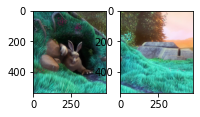

In [47]:
plt.subplot(141)
plt.imshow(imCrop(images[1],2)[0])
plt.subplot(142)
plt.imshow(imCrop(images[1],2)[1])
# plt.subplot(143)
# plt.imshow(imCrop(images[1],4)[2])
# plt.subplot(144)
# plt.imshow(imCrop(images[1],4)[3])

In [33]:
images[1].shape

(540, 960, 3)

In [35]:
images[1][540,480]

IndexError: index 540 is out of bounds for axis 0 with size 540

In [4]:
x=image_slicer.slice('frame_1.jpg',16,save=False)

In [57]:
from PIL import ImageDraw, ImageFont

In [58]:
for tile in x:
    overlay = ImageDraw.Draw(tile.image)

In [59]:
overlay

In [5]:
np.asarray(x[1].image)

array([[[ 35,  45,  36],
        [ 31,  43,  31],
        [ 36,  48,  36],
        ...,
        [ 68,  89, 110],
        [ 62,  77, 100],
        [ 65,  73,  96]],

       [[ 38,  48,  39],
        [ 35,  47,  35],
        [ 40,  52,  40],
        ...,
        [ 70,  93, 109],
        [ 62,  79,  95],
        [ 63,  74,  92]],

       [[ 43,  55,  45],
        [ 43,  57,  44],
        [ 46,  60,  47],
        ...,
        [ 67,  95,  99],
        [ 58,  81,  87],
        [ 56,  75,  82]],

       ...,

       [[ 66,  77,  45],
        [ 61,  72,  38],
        [ 61,  72,  38],
        ...,
        [ 30,  58,  59],
        [ 30,  58,  61],
        [ 30,  58,  61]],

       [[ 59,  70,  38],
        [ 51,  62,  28],
        [ 48,  59,  25],
        ...,
        [ 30,  58,  59],
        [ 29,  57,  60],
        [ 28,  56,  59]],

       [[ 48,  59,  27],
        [ 40,  51,  17],
        [ 38,  49,  15],
        ...,
        [ 29,  57,  58],
        [ 28,  56,  59],
        [ 27,  55,  58]]